# Parabolic partial differential equations

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/laplace_equation.ipynb)

Preamble: Run the cells below to import the necessary Python packages

In [1]:
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Image

%matplotlib inline


# Partial differential equations

We can think of partial differential equations (PDEs) as an infinite set of ordinary differential equations (ODEs). In numerical methods, we split up this set into a finite set of ODEs, usually by "meshing" the domain into a finite set of points.

There are several types of PDEs, elliptical, hyperbolic, and parabolic.

| Type     | Equation | Example     |
| :---        |    :----:   |    :----:   |
| Elliptical      | $u'' + u'' = 0$      | Laplace's equation      |
| Hyperbolic      | $\ddot{u} = u''$       | Wave equation      |
| Parabolic      | $\dot{u} = u''$       | Heat equation      |

where $u' = \frac{\partial u}{\partial x}$ and $\dot{u} = \frac{\partial u}{\partial t}$ in the table.

We will start by focusing on elliptical and parabolic PDEs.


# Diffusion in free space

Suppose we have a quantity $\rho$ that is diffusing in free space.  The diffusion equation states that the rate of change of $\rho$ is proportional to the Laplacian of $\rho$


$$
\dfrac{\partial}{\partial t}\rho(\mathbf{r}) = D \nabla^{2} \rho(\mathbf{r}),
$$

where $D$ is the diffusion constant or diffusivity, which determines how quickly the quantity $\rho$ diffuses. While many analytical solutions exist for the diffusion equation, numerical solutions are particularly valuable for more complicated geometries.

## Laplace's equation

With the diffusion equation, we are usually particularly interested in the steady-state solution, after the system has reached equilibrium.  In this case, the time derivative is zero, and the diffusion equation becomes Laplace's equation

$$
\nabla^{2} \rho(\mathbf{r}) = 0.
$$

The steady-state solution to Laplace's equation gives the equilibrium distribution of $\rho$ in space. This is strongly influenced by the boundary conditions for the system. If the boundary conditions are trivial, as in the Dirichlet boundary conditions $\rho(\mathbf{r}) = 0$ everywhere on the boundary, then the solution is trivial $\rho(\mathbf{r}) = 0$.  However, if the boundary conditions are non-trivial, then the solution can be quite complex

### Boundary value problems

Given some specificiation of the value of $\rho$, $\nabla \rho$, or some combination of these on the boundary of the system, we can solve for the steady-state solution to Laplace's equation.  This is called a boundary value problem.  

We will focus initially on the case of Dirichlet boundary conditions, where the values of $\rho$ are  specified to equal fixed values on the boundary of the system.  Another option would be Neumann boundary conditions, where $\nabla \rho$ (the flux of scalar into the system) is instead specified on the boundary of the system.

## Relaxation Methods for solving Laplace's equation

The interior region in a boundary value problem contains no sources or sinks for the diffusing quantity $\rho$. This means that the value of $\rho$ at some point in the interior of domain is equal to the average value of $\rho$ on the bounday of any enclosing ring via the mean value theorem,

$$ 
\rho(\mathbf{r}) = \frac{1}{2 \pi R} \oint_{\rm \partial S} \rho(\mathbf{r}) d\mathbf{s} 
$$ 
where $\partial S$ is the boundary of a disk $S$ of radius $R$ containing $\mathbf{r}$. This property gives rise to the smoothness of solutions to the Laplace equation.


### Relaxation method

While the mean value property holds globally for any ring around any point in the domain, we can use it to derive an integration scheme in the limit where the enclosing ring corresponds to a discrete spatial mesh of the domain. If discrete spatial points in a 2D domain are indexed by $i$ and $j$, then the mean value property can be written as

$$
\rho_{i,j} = \frac{1}{4} \left( \rho_{i+1,j} + \rho_{i-1,j} + \rho_{i,j+1} + \rho_{i,j-1} \right).
$$

where $\rho_{i,j}$ is the value of $\rho$ at the point $(i,j)$ in the mesh. This is a self-consistent equation for $\rho_{i,j}$, since the right-hand side is a function of $\rho_{i,j}$ and its nearest neighbors.  We can solve this equation iteratively, starting with some initial guess for $\rho_{i,j}$, and then updating the value of $\rho_{i,j}$ at each point in the mesh until the solution converges.

Notice that we are using [the Von Neumann neighborhood](https://en.wikipedia.org/wiki/Von_Neumann_neighborhood), in contrast to the [Moore neighborhood](https://en.wikipedia.org/wiki/Moore_neighborhood) used in the Ising model and in many convolutional models.

In [2]:
class LaplaceEquation:
    """
    Class to solve the Laplace equation in 2D using the Jacobi method.

    Attributes:
        initial_lattice (np.ndarray): Initial lattice with boundary conditions
        max_iterations (int): Maximum number of iterations
        tolerance (float): Tolerance for convergence
        store_history (bool): Whether to store the history of the grid at each iteration

    Methods:
        solve: Solve the Laplace equation
        update_grid: Update the grid site-by-site

    """

    def __init__(self, initial_lattice, max_iterations=10000, tolerance=1e-4, store_history=False):
        self.initial_lattice = initial_lattice
        self.n, self.m = initial_lattice.shape
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.store_history = store_history

    def solve(self):

        ## Initialize grid with zeros
        grid = np.copy(self.initial_lattice)

        if self.store_history:
            self.history = [grid.copy()]

        ## Iterate until convergence
        for iteration in range(self.max_iterations):
            # Copy current grid
            grid_old = np.copy(grid)

            # The actual update and physical simulation goes here
            grid = self.update_grid(grid)
            #y = self.update(t, y)

            ## Store history
            if self.store_history:
                self.history.append(grid.copy())

            ## Check for convergence
            if np.linalg.norm(grid - grid_old) < self.tolerance:
                print('Converged after {} iterations.'.format(iteration))
                break

        return grid

    def update_grid(self, grid):

        # ## Update grid site-by-site
        # for i in range(1, self.n - 1):
        #     for j in range(1, self.m - 1):
        #         grid[i, j] = 0.25 * (grid[i - 1, j] + grid[i + 1, j] + grid[i, j - 1] + grid[i, j + 1])

         ## Vectorized implementation of the above loop
        grid[1:-1, 1:-1] = 0.25 * (grid[:-2, 1:-1] + grid[2:, 1:-1] + grid[1:-1, 0:-2] + grid[1:-1, 2:])
        # grid[1:-1, 1:-1] = 0.25 * (grid[0:-2, 1:-1] + grid[2:, 1:-1] + grid[1:-1, 0:-2] + grid[1:-1, 2:])

        return grid



Text(0.5, 1.0, 'East')

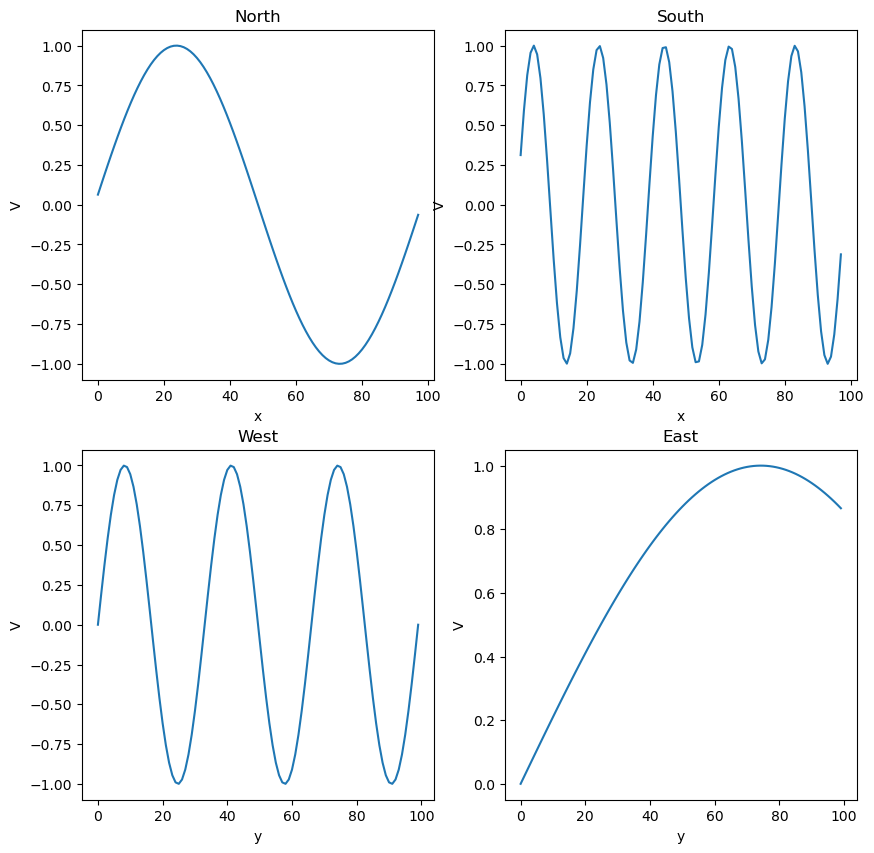

In [3]:
# Define initial lattice and complex boundary conditions
n_x = 100
# n_x = 10
# n_x = 4
initial_lattice = np.zeros((n_x, n_x))
# initial_lattice = np.random.uniform(0, 1, size=(n_x, n_x))
initial_lattice[0, :] = np.sin(np.linspace(0, 2 * np.pi, n_x))
initial_lattice[-1, :] = np.sin(np.linspace(0, 2 * np.pi * 5, n_x))
initial_lattice[:, 0] = np.sin(np.linspace(0, 2 * np.pi * 3, n_x))
initial_lattice[:, -1] = np.sin(np.linspace(0, 2 * np.pi / 3, n_x))

## Plot North, South, East, and West boundary conditions
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.plot(initial_lattice[0, 1:-1])
plt.xlabel('x'); plt.ylabel('V')
plt.title('North')
plt.subplot(222)
plt.plot(initial_lattice[-1, 1:-1])
plt.xlabel('x'); plt.ylabel('V')
plt.title('South')
plt.subplot(223)
plt.plot(initial_lattice[:, 0])
plt.xlabel('y'); plt.ylabel('V')
plt.title('West')
plt.subplot(224)
plt.plot(initial_lattice[:, -1])
plt.xlabel('y'); plt.ylabel('V')
plt.title('East')

In [4]:
initial_lattice

array([[ 0.00000000e+00,  6.34239197e-02,  1.26592454e-01, ...,
        -1.26592454e-01, -6.34239197e-02,  0.00000000e+00],
       [ 1.89251244e-01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  2.11539281e-02],
       [ 3.71662456e-01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  4.22983890e-02],
       ...,
       [-3.71662456e-01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  8.86399525e-01],
       [-1.89251244e-01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  8.76408578e-01],
       [-7.34788079e-16,  3.12033446e-01,  5.92907929e-01, ...,
        -5.92907929e-01, -3.12033446e-01,  8.66025404e-01]],
      shape=(100, 100))

Converged after 8670 iterations.


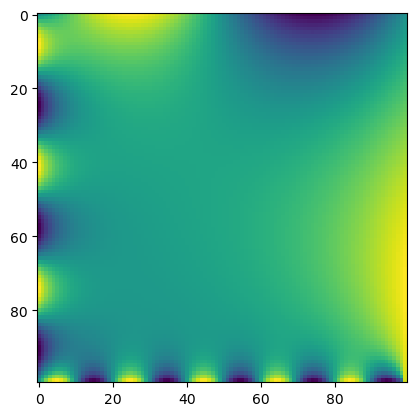

In [5]:
# Solve Laplace equation
model = LaplaceEquation(initial_lattice, max_iterations=10000, store_history=True)

grid = model.solve()

# # Plot grid
plt.imshow(grid, interpolation='nearest')

In [6]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
from IPython.display import display
import ipywidgets as widgets


def plotter(i):
    plt.figure(figsize=(6, 6))
    plt.imshow(model.history[i], interpolation='nearest')
    plt.axis('off')
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(model.history) - 1, 1)
)

interactive(children=(IntSlider(value=0, description='i', max=8671), Output()), _dom_classes=('widget-interact…

<function __main__.plotter(i)>

### Does this match our intuition?

The diffusion term appears to smooth out fluctuations in the field over time, This is a consequence of the intermediate value theorem for harmonic functions, which states that extrema of harmonic functions are always on boundaries, therefore no interior extrema are possible. Note that our implementation of relaxation is a synchronous update (all sites are updated at the same time), similar to the synchronous update we previously used for cellular automata.


## Another approach: Convolutions

The inner loop of our solution method consists of visiting each point in the mesh, and then updating its value based on the average of its neighbors. This is a very simple operation, but it is repeated many times. This update rule is extremely similar to the Game of Life, and other cellular automata that we have seen previously.

Mathematically, we can think of the Laplace equation as a convolution of the potential with a kernel that is a function of the distance between the points. A convolution has the form:

$$
f*g = \int_{-\infty}^{\infty} f(x) g(x-y) dx
$$

where $f$ and $g$ are functions, and $*$ is the convolution operator. In discrete form, this becomes:

$$
f*g = \sum_{i} f(x_i) g(x_i - y_j)
$$

where $f$ and $g$ are now arrays of values, and $*$ is the discrete convolution operator. The convolutional kernel is the function $g$, and it usually only exists on a compact interval. For the Laplace equation, the kernel in continuous time is a Gaussian, and in discrete time is a function that returns only the values of North, South, East, and West neighbors.

We can implement this in Python using the `scipy.signal.convolve2d` function.

In [7]:
from scipy.signal import convolve2d

class LaplaceEquationConvolution(LaplaceEquation):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def update_grid(self, grid):

        ## Define convolution kernel (von Neumann neighborhood)
        kernel = 0.25 * np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

        ## Convolve grid with kernel. Note how we handle the boundary conditions.
        grid[1:-1, 1:-1] = convolve2d(grid, kernel, mode='same')[1:-1, 1:-1]

        return grid

Let's test out this new approach, to see how it compares to our previous implementation.

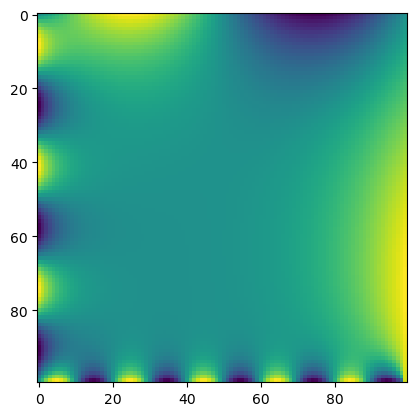

In [8]:
## Solve Laplace equation
model = LaplaceEquationConvolution(initial_lattice, max_iterations=1000, store_history=True)

grid = model.solve()

# Plot grid
plt.imshow(grid, interpolation='nearest')

We can also plot the evolution of the field at a single lattice site over time.

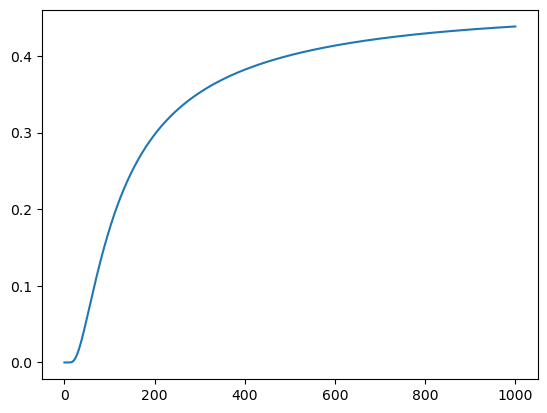

In [9]:
plt.plot([item[10, 10] for item in model.history])

## How does the accuracy depend on the mesh size?

The critical assumption in the relaxation method is that the mean value property holds for the discrete mesh. This degrades as the mesh size increases, because the mesh values no longer approximate a continuous contour. Below, we perform two simulations, one with a fine mesh and one with a coarse mesh. We then downsample the results of the fine mesh to the coarse mesh, in order to see what the "ground truth" should be for the coarse mesh

Converged after 8670 iterations.
Converged after 22 iterations.


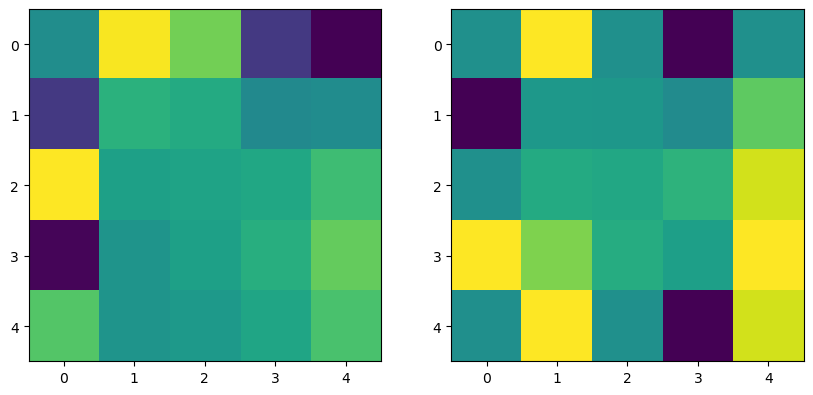

In [10]:
downsample_factor = 20

n_x = 100
initial_lattice = np.zeros((n_x, n_x))
initial_lattice[0, :] = np.sin(np.linspace(0, 2 * np.pi, n_x))
initial_lattice[-1, :] = np.sin(np.linspace(0, 2 * np.pi * 5, n_x))
initial_lattice[:, 0] = np.sin(np.linspace(0, 2 * np.pi * 3, n_x))
initial_lattice[:, -1] = np.sin(np.linspace(0, 2 * np.pi / 3, n_x))
model = LaplaceEquation(initial_lattice, max_iterations=10000, store_history=True)
grid1 = model.solve()


n_x = n_x // downsample_factor
initial_lattice = np.zeros((n_x, n_x))
initial_lattice[0, :] = np.sin(np.linspace(0, 2 * np.pi, n_x))
initial_lattice[-1, :] = np.sin(np.linspace(0, 2 * np.pi * 5, n_x))
initial_lattice[:, 0] = np.sin(np.linspace(0, 2 * np.pi * 3, n_x))
initial_lattice[:, -1] = np.sin(np.linspace(0, 2 * np.pi / 3, n_x))
model = LaplaceEquation(initial_lattice, max_iterations=10000, store_history=True)
grid2 = model.solve()


## Plot side-by-side
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(grid1[::downsample_factor, ::downsample_factor], interpolation='nearest')
plt.subplot(122)
plt.imshow(grid2, interpolation='nearest')

### Remember the convolution theorem?

$$
\mathcal{F}[f*g] = \mathcal{F}[f] \cdot \mathcal{F}[g]
$$
where $\mathcal{F}$ is the Fourier transform. This is a very useful result, because it allows us to convolve functions in the frequency domain, which is much faster than convolving in the time domain.

+ This is a clue that the Fourier transform is a useful tool for solving PDEs.
+ Intuition: sines and cosines are the eigenfunctions of translation operators

### Links to cellular automata

Our convolutional implementation of the Laplace equation is very similar to the Game of Life implementation that we saw earlier in the course. In general, many cellular automata have integral update structure, where each site is updated based on the values of its neighbors. However, we have also seen examples of cellular automata with differential update structure, where a set of neighbors is updated based on their difference from the center site. The sandpile model is an example of this.

## Solving Laplace's equation with finite-differences

With the Laplace equation, we were able to use our domain knowledge to devise a *relaxation* solution scheme that approximates the path integral around a mesh cell.

In general, we can't usually do this for other PDEs. Instead, we must use a more general method to solve the differential equation. The simplest method is to use a finite-difference method, which is a method of approximating the derivative of a function by using the values of the function at two or more points.

Suppose that we want to solve the heat equation in a 2D domain, $u(x,y,t)$, where the initial condition is $u(x,y,0) = f(x,y)$, and the boundary conditions are $u(x,y,t) = 0$ for $x = 0$ and $x = L$. The heat equation is:

$$
    \frac{\partial u}{\partial t} = D \left( \frac{\partial^{2} u}{\partial x^{2}} + \frac{\partial^{2} u}{\partial y^{2}} \right)
$$

where $\alpha$ is the thermal diffusivity. We can solve this equation by discretizing in time, and then using the finite difference method to discretize in space. The resulting equation is:

$$
    \frac{u_{i,j}^{n+1} - u_{i,j}^{n}}{\Delta t} = D \left( \frac{u_{i+1,j}^{n} - 2u_{i,j}^{n} + u_{i-1,j}^{n}}{\Delta x^{2}} + \frac{u_{i,j+1}^{n} - 2u_{i,j}^{n} + u_{i,j-1}^{n}}{\Delta y^{2}} \right)
$$

where $u_{i,j}^{n}$ is the value of $u$ at the point $(x_i, y_j)$ at time $t_n$. We can rearrange this equation to solve for $u_{i,j}^{n+1}$:

$$
    u_{i,j}^{n+1} = u_{i,j}^{n} + D\left( \frac{\Delta t}{\Delta x^{2}} \left( u_{i+1,j}^{n} - 2u_{i,j}^{n} + u_{i-1,j}^{n} \right) + \frac{\Delta t}{\Delta y^{2}} \left( u_{i,j+1}^{n} - 2u_{i,j}^{n} + u_{i,j-1}^{n} \right) \right)
$$

We can use the same approach as before, and use a loop to update the values of $u$ at each time step.

/var/folders/r2/_n_91pks3n9f792s90nk2p740000gn/T/ipykernel_12134/4092704738.py:84: RuntimeWarning: overflow encountered in add
  grid[1:-1, 1:-1] = grid[1:-1, 1:-1] + self.dt * self.diffusivity * (k2 + k3 + k4 + k5 - 4 * k1) / self.dx**2
/var/folders/r2/_n_91pks3n9f792s90nk2p740000gn/T/ipykernel_12134/4092704738.py:84: RuntimeWarning: overflow encountered in multiply
  grid[1:-1, 1:-1] = grid[1:-1, 1:-1] + self.dt * self.diffusivity * (k2 + k3 + k4 + k5 - 4 * k1) / self.dx**2
/var/folders/r2/_n_91pks3n9f792s90nk2p740000gn/T/ipykernel_12134/4092704738.py:84: RuntimeWarning: overflow encountered in subtract
  grid[1:-1, 1:-1] = grid[1:-1, 1:-1] + self.dt * self.diffusivity * (k2 + k3 + k4 + k5 - 4 * k1) / self.dx**2
/var/folders/r2/_n_91pks3n9f792s90nk2p740000gn/T/ipykernel_12134/4092704738.py:84: RuntimeWarning: invalid value encountered in add
  grid[1:-1, 1:-1] = grid[1:-1, 1:-1] + self.dt * self.diffusivity * (k2 + k3 + k4 + k5 - 4 * k1) / self.dx**2


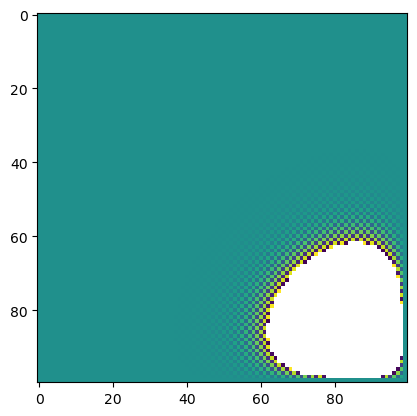

In [11]:
class LaplaceFiniteDifference:
    """
    A class to solve the Laplace equation using the finite difference method.
    
    Attributes:
        initial_lattice : np.ndarray
            The initial state of the lattice/grid.
        diffusivity : float, optional
            The diffusivity constant (default is 1.0).
        dt : float, optional
            The time step size (default is 1e-3).
        L : float, optional
            The length of the domain (default is 1.0).
        max_iterations : int, optional
            The maximum number of iterations (default is 10000).
        tolerance : float, optional
            The convergence tolerance (default is 1e-4).
        store_history : bool, optional
            Whether to store the history of the grid states (default is False).
   
    Methods:
        solve():
            Solves the Laplace equation until convergence or maximum iterations.
        update_grid(grid):
            Updates the grid using the finite difference method.
    """

    def __init__(self, initial_lattice, diffusivity=1.0, dt=1e-3, L=1.0, 
                 max_iterations=20000, tolerance=1e-5, store_history=False):

        self.initial_lattice = initial_lattice
        self.max_iterations = max_iterations
        self.tolerance = tolerance

        self.store_history = store_history
        self.diffusivity = diffusivity
        self.dt = dt
        self.dx = L / (initial_lattice.shape[0] - 1)

    def solve(self):

        ## Initialize grid
        grid = self.initial_lattice.copy()

        ## Initialize history
        if self.store_history:
            self.history = [grid.copy()]

        ## Initialize iteration counter
        iteration = 0

        ## Initialize error
        error = np.inf

        ## Iterate until convergence
        while iteration < self.max_iterations and error > self.tolerance:
                
            ## Update grid
            grid = self.update_grid(grid)

            ## Update iteration counter
            iteration += 1
           
            ## Update error
            error = np.max(np.abs(grid - self.history[-1]))
            if error < self.tolerance:
                print(f'Converged after {iteration} iterations.')
                break
            ## Update history
            if self.store_history:
                self.history.append(grid.copy())

        return grid

    def update_grid(self, grid):
        ## Update grid using finite difference method
        
        k1 = grid[1:-1, 1:-1]
        k2 = grid[1:-1, 2:]
        k3 = grid[1:-1, :-2]
        k4 = grid[2:, 1:-1]
        k5 = grid[:-2, 1:-1]

        grid[1:-1, 1:-1] = grid[1:-1, 1:-1] + self.dt * self.diffusivity * (k2 + k3 + k4 + k5 - 4 * k1) / self.dx**2
        # grid[1:-1, 1:-1] = grid[1:-1, 1:-1] + self.dt * self.diffusivity * (k2 + k3 + k4 + k5 - 4 * k1) / self.dx**2

        return grid

        

# Define initial lattice and complex boundary conditions
n_x = 100
initial_lattice = np.zeros((n_x, n_x))
initial_lattice[0, :] = np.sin(np.linspace(0, 2 * np.pi, n_x))
initial_lattice[-1, :] = np.sin(np.linspace(0, 2 * np.pi * 5, n_x))
initial_lattice[:, 0] = np.sin(np.linspace(0, 2 * np.pi * 3, n_x))
initial_lattice[:, -1] = np.sin(np.linspace(0, 2 * np.pi / 3, n_x))

# from scipy.signal import convolve2d

## Solve Laplace equation
# model = LaplaceFiniteDifference(initial_lattice, dt=1e-3, max_iterations=10000, store_history=True)
# model = LaplaceFiniteDifference(initial_lattice, dt=1e-4, max_iterations=10000, store_history=True)
model = LaplaceFiniteDifference(initial_lattice, dt=6e-5, max_iterations=20000, store_history=True)

grid = model.solve()

# Plot grid
plt.imshow(model.history[-1], interpolation='nearest')





In [12]:
1/(model.diffusivity * 2 / model.dx**2)

5.101520253035405e-05

Text(0, 0.5, 'Scalar field at middle pixel')

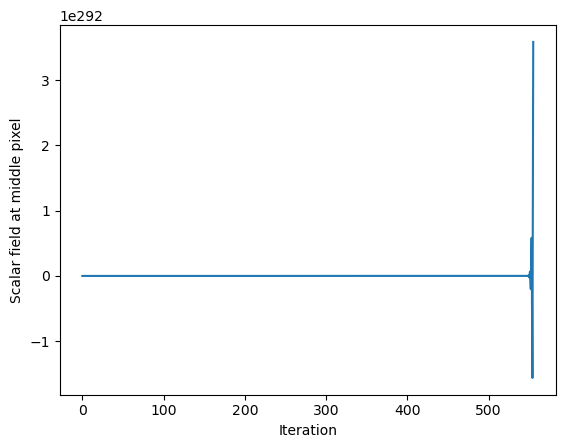

In [13]:
plt.plot([item[10, 10] for item in model.history])
plt.xlabel('Iteration')
plt.ylabel('Scalar field at middle pixel')

In [14]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
from IPython.display import display
import ipywidgets as widgets


def plotter(i):
    plt.figure(figsize=(6, 6))
    plt.imshow(model.history[i], interpolation='nearest')
    plt.axis('off')
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(model.history) - 1, 1)
)

interactive(children=(IntSlider(value=0, description='i', max=555), Output()), _dom_classes=('widget-interact'…

<function __main__.plotter(i)>

### Questions

+ Try modifying the space and time steps. What happens to the solution?

+ How would you expect the solution to change if the domain was a disk? Or a ring?

<br><br><br><br><br><br>

# Stability of finite-difference schemes for the diffusion equation

### The 1D Laplacian is a matrix

To understand the origin of instability, let's write down the 1D discretized diffusion equation.

$$
\frac{u_{i}^{n+1} - u_{i}^{n}}{\Delta t} = D \frac{u_{i+1}^{n} - 2u_{i}^{n} + u_{i-1}^{n}}{\Delta x^{2}}
$$

We can write this as a discrete-time update equation in matrix form:

$$
\mathbf{u}_{n+1} = \mathbf{u}_{n} + D \dfrac{\Delta t}{\Delta x^2} \mathbf{L} \mathbf{u}_{n}
$$

where $\mathbf{u} \in \mathbb{R}^{N}$ is a vector of the values of $u$ at each point in the mesh, and $\mathbf{L} \in \mathbb{R}^{N \times N}$ is the 1D Laplacian matrix.

The 1D Laplacian is a matrix, and we can use matrix algebra to represent some operators. If we have $N$ points in our discretized mesh of $\mathbf{u}$, then 1D Laplacian is given by and $N \times N$ matrix:

$$
\mathbf{L} = \frac{1}{\Delta x^{2}} \begin{bmatrix}
-2 & 1 & 0 & \cdots & 0 & 0 & 0 & 0 & 1 \\
1 & -2 & 1 & \cdots & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & -2 & \cdots & 0 & 0 & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & -2 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & \cdots & 1 & -2 & 1 & 0 & 0 \\
0 & 0 & 0 & \cdots & 0 & 1 & -2 & 1 & 0 \\
0 & 0 & 0 & \cdots & 0 & 0 & 1 & -2 & 1 \\
1 & 0 & 0 & \cdots & 0 & 0 & 0 & 1 & -2 \\
\end{bmatrix} 
$$


In 2D we are not so lucky. We have to use convolutions, or flatten the $N \times N$ lattice into a vector of length $N^2$. But the linear operator $\mathbf{L}$ can still be defined in the same way.

<br><br><br><br><br><br>

## Boundary conditions

+ For our examples so far, we've specified the boundary conditions as $u(\mathbf{x}, t) = u_0(\mathbf{x})$ for all $\mathbf{x} \in \partial \Omega$, where $\Omega$ denotes our solution domain (square, disk, etc). 
+ Our cases so far have been *Dirichlet* boundary conditions, where we specify the value of $u$ at the boundary.
+ We can also have *Neumann* boundary conditions, where we specify the value of the derivative of $u$ at the boundary. For example, we could specify $\nabla u(\mathbf{x}, t) \cdot \mathbf{\hat{t}} = f_0(\mathbf{x})$ for all $\mathbf{x} \in \partial \Omega$, where $\mathbf{\hat{t}}$ is a unit vector normal to the boundary. This type of boundary condition specifies a fixed flux of the scalar field through the boundary.
+ We can also have *mixed* or Robin boundary conditions, where we specify a combination of Dirichlet and Neumann boundary conditions. $u(\mathbf{x}, t) + \nabla u(\mathbf{x}, t) \cdot \mathbf{\hat{t}}  = g_0(\mathbf{x})$ for all $\mathbf{x} \in \partial \Omega$.


### 1D Laplacian with various boundary conditions

The 1D Laplacian with Dirichlet boundary conditions has the form

$$
\mathbf{L} = \frac{1}{\Delta x^{2}} 
\begin{bmatrix}
-2 & 1 & 0 & \cdots & 0 & 0 & 0 & 0 & 0 \\
1 & -2 & 1 & \cdots & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & -2 & \cdots & 0 & 0 & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & -2 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & \cdots & 1 & -2 & 1 & 0 & 0 \\
0 & 0 & 0 & \cdots & 0 & 1 & -2 & 1 & 0 \\
0 & 0 & 0 & \cdots & 0 & 0 & 1 & -2 & 1 \\
0 & 0 & 0 & \cdots & 0 & 0 & 0 & 1 & -2 \\
\end{bmatrix}
$$

The 1D Laplacian with Neumann (reflection) boundary conditions has the form

$$
\mathbf{L} = \frac{1}{\Delta x^{2}} 
\begin{bmatrix}
-1 & 1 & 0 & \cdots & 0 & 0 & 0 & 0 & 0 \\
1 & -2 & 1 & \cdots & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & -2 & \cdots & 0 & 0 & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & -2 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & \cdots & 1 & -2 & 1 & 0 & 0 \\
0 & 0 & 0 & \cdots & 0 & 1 & -2 & 1 & 0 \\
0 & 0 & 0 & \cdots & 0 & 0 & 1 & -2 & 1 \\
0 & 0 & 0 & \cdots & 0 & 0 & 0 & 1 & -1 \\
\end{bmatrix}
$$

The 1D Laplacian with periodic boundary conditions has the form

$$
\mathbf{L} = \frac{1}{\Delta x^{2}} 
\begin{bmatrix}
-2 & 1 & 0 & \cdots & 0 & 0 & 0 & 0 & 1 \\
1 & -2 & 1 & \cdots & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & -2 & \cdots & 0 & 0 & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & -2 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & \cdots & 1 & -2 & 1 & 0 & 0 \\
0 & 0 & 0 & \cdots & 0 & 1 & -2 & 1 & 0 \\
0 & 0 & 0 & \cdots & 0 & 0 & 1 & -2 & 1 \\
1 & 0 & 0 & \cdots & 0 & 0 & 0 & 1 & -2 \\
\end{bmatrix}
$$



## Stability of finite difference schemes

The 1D discretized diffusion equation is given by

$$
    \mathbf{u}_{n+1} = \mathbf{u}_{n} + D \Delta t \mathbf{L} \mathbf{u}_{n}
$$

we can group terms on the right-hand side to get

$$
    \mathbf{u}_{n+1} = (I + D \Delta t \mathbf{L}) \mathbf{u}_{n}
$$

Recall that a linear dynamical system has the form

$$
\mathbf{x}_{t + 1} = A \mathbf{x}_{t}
$$

where $A$ is a matrix. We can think of this as a map from $\mathbb{R}^N \to \mathbb{R}^N$.

Depending on whether $\max_i |\lambda_i| < 1$, $\max_i |\lambda_i| = 1$, or $\max_i |\lambda_i| > 1$, the system will be stable, marginally stable, or unstable.

Eigenvalues of symmetric transition matrix:  [0.94748113 0.02415408]


Text(0.5, 0, 'Time step')

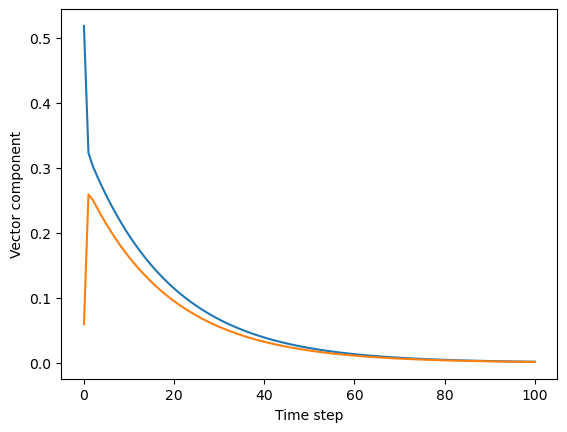

In [15]:
## Sample a random 2 x 2 symmetric matrix
a = 0.3 * np.random.random((2, 2))
# a = np.random.random((2, 2))
a += a.T
print("Eigenvalues of symmetric transition matrix: ", np.linalg.eigvals(a))

## Simulate dynamics starting from a random initial 2D vector
all_u = [np.random.random(2)]
for _ in range(100):
    all_u.append(a @ all_u[-1])
all_u = np.array(all_u)

plt.figure()
plt.plot(all_u[:, 0])
plt.plot(all_u[:, 1])
plt.ylabel("Vector component")
plt.xlabel("Time step")


## Implementing a finite difference scheme for the 1D diffusion equation

In one dimension, the diffusion equation is given by

$$
\frac{\partial}{\partial t}u(x,t) = D\frac{\partial^2}{\partial x^2} u(x,t)
$$

We can approximate this equation using first-order finite differences in space and time

$$
\frac{u(x, t + \Delta t) - u(x, t)}{\Delta t} = D \frac{u(x + \Delta x, t) - 2 u(x, t) + u(x - \Delta x, t)}{\Delta x^2}
$$

We use the index $i$ to denote different lattice points in space, and $n$ to denote different time steps. We rearrange terms to write this equation as a matrix equation that updates $u_i$ at each time step

$$
u_i^{n + 1} = u_i^n + \frac{\Delta t D}{\Delta x^2} \left(u_{i + 1}^n - 2 u_i^n + u_{i - 1}^n\right)
$$

Notice that we can write the right-hand side of this differential equation as a constant matrix $\mathbb{I} + L$ acting on the vector $\mathbf{u}^n$

$$
\mathbf{u}^{n + 1} = \left(\mathbb{I} + \frac{\Delta t D}{\Delta x^2}A\right) \mathbf{u}^n
$$

where $A$ is a tridiagonal matrix with $-2$ on the diagonal, and $1$ on the off-diagonals. In general, we can always write *linear* partial differential equations as linear matrix equations in discrete time.


Max norm eigenvalues of update operator:  0.9999999999999977


Text(0, 0.5, 'x')

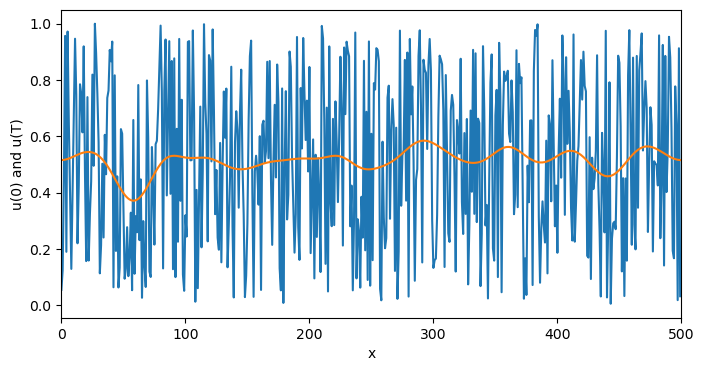

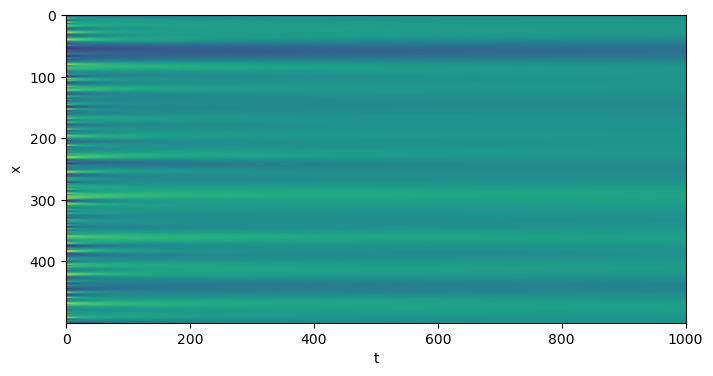

In [16]:
def laplacian(n, dx=1.0):
    """
    Create a one-dimensional discrete Laplacian operator with periodic boundary conditions.

    Args:
        n (int): The number of grid points.
        dx (float): The grid spacing.

    Returns:
        ndarray: The Laplacian operator in one dimension.
    """
    op = np.zeros((n, n))

    # set diag to -2
    np.fill_diagonal(op, -2)

    # set off-diag to 1
    np.fill_diagonal(op[:, 1:], 1)
    np.fill_diagonal(op[1:, :], 1)

    # set periodic boundary conditions
    op[0, -1] = 1
    op[-1, 0] = 1

    return op / dx**2


class DiscretizedPDE:
    """
    A base class for discretized PDEs in one dimension.

    Parameters
        n (int): The number of grid points in one dimension
        dx (float): The grid spacing
        dt (float): The time step
        store_history (bool): Whether to store the history of the solution
        random_state (int): The random seed

    """

    def __init__(self, n, dx=1.0, dt=1.0, store_history=True, random_state=0, verbose=False):
        self.n = n
        self.dt = dt
        self.dx = dx
        self.store_history = store_history
        self.random_state = random_state
        self.verbose = verbose

    def rhs(self, u):
        raise NotImplementedError
    
    def solve(self, u0, nt):
        u = u0
        if self.store_history:
            self.history = [u0.copy()]
        for i in range(nt):
            u += self.rhs(u) * self.dt
            if self.store_history:
                self.history.append(u.copy())
        return u
    
class DiffusionEquation(DiscretizedPDE):
    """
    A class for discretized diffusion equations in one dimension.
    """
    def __init__(self, D=1.0, **kwargs):
        super().__init__(**kwargs)
        self.D = D
        self.lap = laplacian(self.n, self.dx)

        if self.verbose:
            ## print the eigenvalues of the iteration operator
            print("Max norm eigenvalues of update operator: ", 
                np.max(
                    np.abs(
                        np.linalg.eigvals(np.eye(self.n) + self.D * self.dt * self.lap
                        )
                    )
                )
            )

    def rhs(self, u):
        return self.D * self.lap @ u
    
eq = DiffusionEquation(n=500, dx=1.0, dt=0.08, D=1.0, store_history=True, verbose=True)
# eq = DiffusionEquation(n=500, dx=1.0, dt=1.0, D=1.0, store_history=True, verbose=True)

# Initial condition
u0 = np.random.random(500).copy()

# Solve the equation
u = eq.solve(u0, 1000)

plt.figure(figsize=(8, 4))
plt.plot(eq.history[0])
plt.plot(eq.history[-1])
plt.xlim(0, len(u0))
plt.xlabel("x")
plt.ylabel("u(0) and u(T)")
    
plt.figure(figsize=(8, 4))
plt.imshow(np.array(eq.history).T, aspect='auto')
plt.xlabel("t")
plt.ylabel("x")


#### Can we perform fewer operations?

Suppose we want to do the numerical integration a lot faster. One option might be to increase $\Delta t$ and $\Delta x$. But is there a limit to how far we can go? Let's do a simple experiment to find out.

Max norm eigenvalues of update operator:  0.9999999999999993
Max norm eigenvalues of update operator:  1.0
Max norm eigenvalues of update operator:  3.0000000000000164


Text(0.5, 1.0, 'Δt = 1.0')

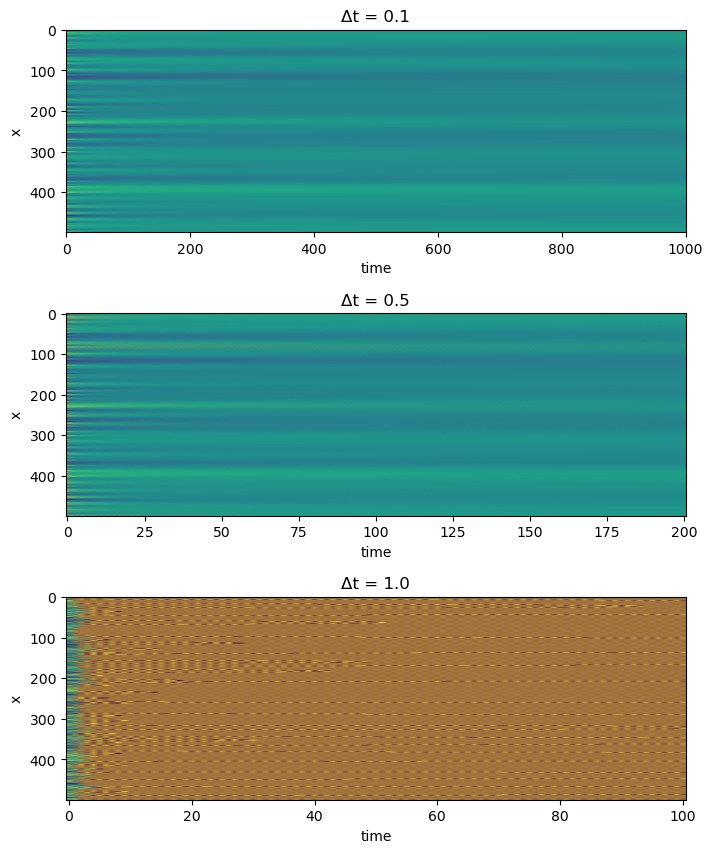

In [17]:

# Initial condition
u0 = np.random.random(500)

# make three subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 10))
plt.subplots_adjust(wspace=0.0, hspace=0.4)

eq = DiffusionEquation(n=500, dx=1.0, dt=0.1, D=1.0, store_history=True, verbose=True)
u = eq.solve(u0.copy(), 1000)

# make figure subplot
plt.subplot(3, 1, 1)
plt.imshow(np.array(eq.history).T, aspect='auto', vmin=0, vmax=1)
plt.xlabel("time")
plt.ylabel("x")
plt.title("Δt = 0.1")

eq = DiffusionEquation(n=500, dx=1.0, dt=0.5, D=1.0, store_history=True, verbose=True)
u = eq.solve(u0.copy(), 200)
plt.subplot(3, 1, 2)
plt.imshow(np.array(eq.history).T, aspect='auto', vmin=0, vmax=1)
plt.xlabel("time")
plt.ylabel("x")
plt.title("Δt = 0.5")

eq = DiffusionEquation(n=500, dx=1.0, dt=1.0, D=1.0, store_history=True, verbose=True)
u = eq.solve(u0.copy(), 100)
plt.subplot(3, 1, 3)
plt.imshow(np.array(eq.history).T, aspect='auto', vmin=0, vmax=1)
plt.xlabel("time")
plt.ylabel("x")
plt.title("Δt = 1.0")


## We now repeat this experiment for many different values of the timestep

Text(0, 0.5, 'Max field value')

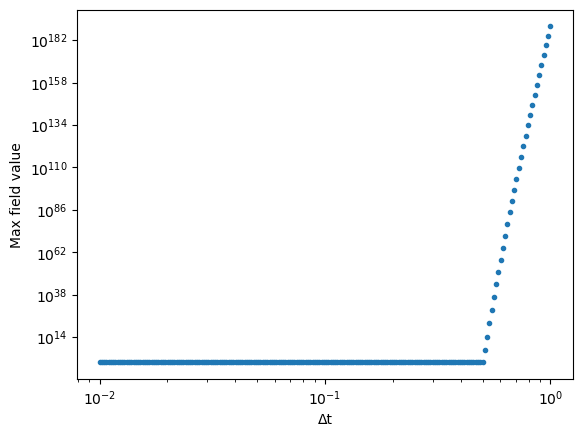

In [18]:
dt_vals = np.logspace(-2, 0, 200)
max_field = []
for dt_val in dt_vals:
    eq = DiffusionEquation(n=500, dx=1.0, dt=dt_val, D=1.0, store_history=True)
    u = eq.solve(u0.copy(), 400)
    max_field.append(np.max(np.abs(u)))

plt.figure()
plt.loglog(dt_vals, max_field, '.')
plt.xlabel("Δt")
plt.ylabel("Max field value")

We suspect that this instability arises due to the matrix that we are iterating changing from having a converging behavior to a diverging behavior, as we saw above. Because the growth factor is a function of the largest eigenvalues of the matrix (as we saw in the power method), we can show this instability analytically.

Recall that our discrete time, discrete-space diffusion equation is

$$
    \mathbf{u}^{n + 1} = \left(\mathbb{I} + \frac{\Delta t D}{\Delta x^2}A\right) \mathbf{u}^n
$$

Due to the periodic boundary conditions, can be shown that the eigenvalues of $\mathbb{I} + A$ are

$$
    \lambda_n = 1 + \frac{\Delta t D}{\Delta x^2}\left(-2 - 2 \cos\left(\frac{\pi n}{N}\right)\right)
$$

where $N$ is the number of lattice points and $n \in [0, N - 1]$. We are particularly interested in the maximum eigenvalue, which determines the growth factor of the system after many iterations.

We can compute the spectrum analytically for the choices of $N$, $\Delta t$, and $\Delta x$ that we used in the simulation above. We can then plot the expected maximum eigenvalue as a function of $\Delta t$.



Text(0, 0.5, 'Condition number')

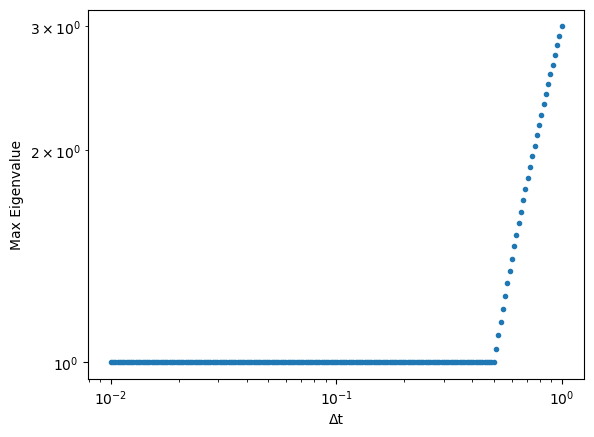

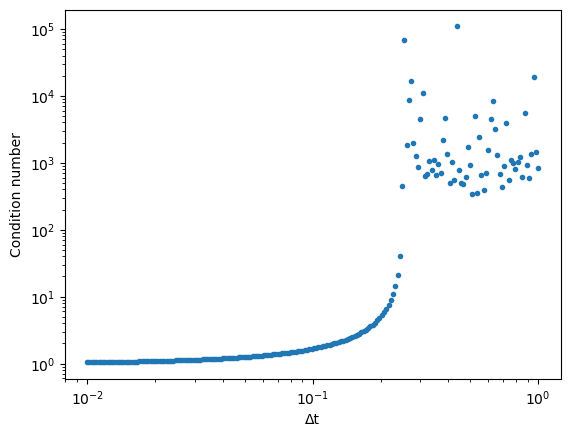

In [19]:
def eigenvalues_diffusion(n, dx=1.0, dt=1.0, D=1.0):
    """
    Compute the eigenvalues of the diffusion equation in one dimension.

    Args:
        n (int): The number of grid points.
        dx (float): The grid spacing.
        dt (float): The time step.
        D (float): The diffusion coefficient.

    Returns:
        ndarray: The eigenvalues of the diffusion equation.
    """
    nvals = np.arange(n)
    return 1 - (D * dt / dx**2) * (2 * np.cos(np.pi * nvals / n) + 2)

# plt.plot(eigenvalues_diffusion(500, dt=0.1, D=1.0))


max_eig, min_eig = [], []
all_conds = []
p2 = []
for dt_val in dt_vals:
    eigs_diff = eigenvalues_diffusion(500, dx=1.0, dt=dt_val, D=1.0)
    max_eig.append(np.max(np.abs(eigs_diff)))
    min_eig.append(np.min(np.abs(eigs_diff)))
    cond = np.max(np.abs(eigs_diff)) / np.min(np.abs(eigs_diff))
    all_conds.append(cond)
    # plt.plot(eigs_diff)

    ## We could also compute the condition number of the propagation matrix directly
    ## But this is more computationally expensive
    # eq = DiffusionEquation(n=500, dx=1.0, dt=dt_val, D=1.0)
    # prop = np.identity(500) + (eq.D * eq.dt / eq.dx**2) * eq.lap
    # cond = np.linalg.cond(prop)
    # all_conds.append(cond)



plt.figure()
plt.loglog(dt_vals, max_eig, '.')
plt.xlabel("Δt")
plt.ylabel("Max Eigenvalue")

plt.figure()
plt.loglog(dt_vals, all_conds, '.')
plt.xlabel("Δt")
plt.ylabel("Condition number")

# n=500, dx=1.0, dt=dt_val, D=1.0, 


### von Neumann stability condition

We can see that the abrupt divergence in the dynamics of the simulation arises from the largest-norm eigenvalue rapidly increasing as we increase $\Delta t$. This abrupt change suggests that an abrupt change occurs in the underlying spectrum $\lambda_n$.

It turns out that we can trace this discontinuity to the discontinuous max function in $\max_n |\lambda_{n}|$. The value of $i$ that maximizes $|\lambda_n|$ abruptly changes.

$$
\lambda_n = 1 - \frac{\Delta t D}{\Delta x^2}\left(2 + 2 \cos\left(\frac{\pi n}{N}\right)\right)
$$

Because the cosine function changes monotonically on the interval $[0, \pi / 2]$, the only two options for the maximum $n$ occur at the endpoints of the interval $[0, N - 1]$. We see why this is the case by plotting the \abs{\lambda_n} as a function of $n$ for various values of $\Delta t$.

In [20]:
dt_vals = np.logspace(-2, 0, 200)
def eigenvalues_diffusion(n, dx=1.0, dt=1.0, D=1.0):
    """
    Compute the eigenvalues of the diffusion equation in one dimension.

    Args:
        n (int): The number of grid points.
        dx (float): The grid spacing.
        dt (float): The time step.
        D (float): The diffusion coefficient.

    Returns:
        ndarray: The eigenvalues of the diffusion equation.
    """
    nvals = np.arange(n)
    return 1 - (D * dt / dx**2) * (2 * np.cos(np.pi * nvals / n) + 2)

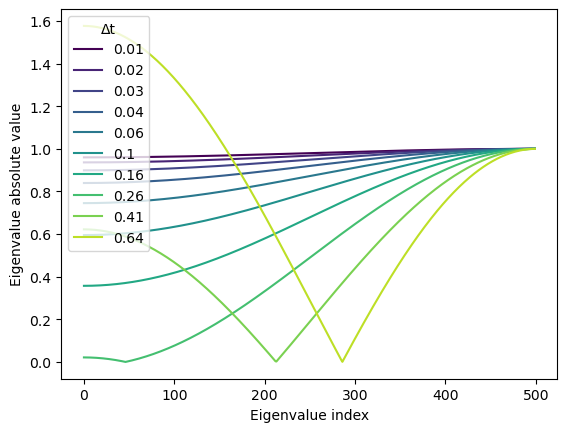

In [21]:
for i, dt_val in enumerate(dt_vals[::20]):
    eigs_diff = eigenvalues_diffusion(500, dx=1.0, dt=dt_val, D=1.0)
    # plt.figure()
    plt.plot(np.abs(eigs_diff), color=plt.cm.viridis(i / len(dt_vals[::20])))

plt.xlabel("Eigenvalue index")
plt.ylabel("Eigenvalue absolute value")
plt.legend(np.round(dt_vals[::20], 2), title="Δt")



Thus, the maximum of the set of eigenvalues is at either end of the interval,

$$
\max_n |\lambda_{n}| = \left\{
    |1 - 4\frac{\Delta t D}{\Delta x^2}|, 
    1 - \frac{\Delta t D}{\Delta x^2}\left(2 + 2 \cos\left(\frac{\pi (N-1)}{N}\right)\right)
\right\}
$$

In the limit $N\rightarrow\infty$, we can simplify this expression,
$$
\max_n |\lambda_{n}| = \left\{
    |1 - 4\frac{\Delta t D}{\Delta x^2}|, \;\;\;
    1
\right\}
$$

The crossover point therefore corresponds to the condition

$$
\dfrac12 = \frac{\Delta t D}{\Delta x^2}
$$

which, for our parameter values, corresponds to $\Delta t = 1/2$. This condition relating the diffusivity, timestep, and lattice discretization represents an example of [von Neumann stability analysis](https://en.wikipedia.org/wiki/Von_Neumann_stability_analysis) for finite difference schemes.


# Questions

+ Why did we call the `laplacian` function in the `__init__` method of the `Diffusion` class? Why not call it within the `rhs` method?

+ A common hyperbolic PDE is the wave equation:

$$
\frac{\partial^2}{\partial t^2}u(x,t) = c^2\frac{\partial^2}{\partial x^2} u(x,t)
$$

where $c$ is the speed of the wave. Based on the stability conditions that we derived previously, what would you expect the linear stability condition for this equation to be?